# Solution (R)

## Install Libraries

In [1]:
library("reshape2")
library("ggplot2")
options(warn=-1)

## Functions to Read in Data

In [2]:
# Counts are stored in csv files.
read.counts <- function(filename) {
    data <- read.csv(filename, header=TRUE);
    return(data);
}

# Contexts are stored in tab separated files because sentences sometimes have commas.
read.context <- function(filename) {
    data <- read.table(filename, sep="\t", header=TRUE, quote="");
    return(data);
}

## <strong> 1.	The Michel et al study used frequency plots of year ngrams (such as '1883') to show that the use of years' ngrams have decreased faster over time. They use these plots to conclude that we "forget faster" as a society. However, critics state that the Google ngrams data contains an overabundance of academic literature, which might render these conclulsions invalid.

Use the included data from the COHA database to create frequency plots for the years '1883', '1910', and '1950'. Do these plots show similar trends to those shown in Figure 3a? </strong>

Like the Google NGrams data, the plots of ngram frequencies over time could also be seen as exponential curves.

In [3]:
# Get data for each ngram.
countsfilename.1883 = "coha_1883_counts.csv";
counts.1883 = read.counts(countsfilename.1883);
counts.1883$FREQ = counts.1883$NUM_PER_MILLION * 1.0 / 1000000;

countsfilename.1910 = "coha_1910_counts.csv";
counts.1910 = read.counts(countsfilename.1910);
counts.1910$FREQ = counts.1910$NUM_PER_MILLION * 1.0 / 1000000;

countsfilename.1950 = "coha_1950_counts.csv";
counts.1950 = read.counts(countsfilename.1950);
counts.1950$FREQ = counts.1950$NUM_PER_MILLION * 1.0 / 1000000;

years = counts.1883$YEAR

In [4]:
freqs_data <-
  data.frame(
    freqs.1883 = counts.1883$FREQ,
    freqs.1910 = counts.1910$FREQ,
    freqs.1950 = counts.1950$FREQ,
    year = years
  );

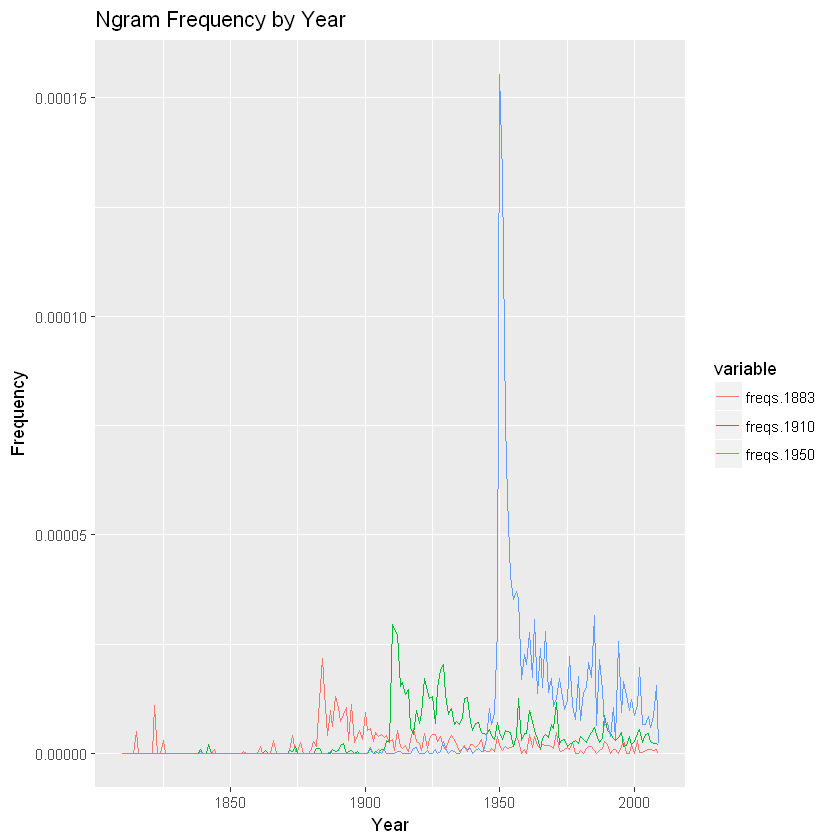

In [5]:
freqs_data_long <- melt(freqs_data, id="year")  # convert to long format
ggplot(subset(freqs_data_long, variable %in% c("freqs.1883", "freqs.1910", "freqs.1950")),
       aes(x=year,
           y=value,
           color=variable))+
  geom_line()+
  ggtitle('Ngram Frequency by Year')+
  xlab('Year')+
  ylab('Frequency')

For comparison, the Google NGrams frequency plots:

In [6]:
IRdisplay::display_html('<iframe src="https://books.google.com/ngrams/interactive_chart?content=1883%2C+1910%2C+1950&year_start=1800&year_end=2000&corpus=15&smoothing=3&share=&direct_url=t1%3B%2C1883%3B%2Cc0%3B.t1%3B%2C1910%3B%2Cc0%3B.t1%3B%2C1950%3B%2Cc0" width=900, height=400></iframe> ')

To test whether the "forgetting faster" effect exists in the COHA corpus, we compute the halflife two ways. In Michel et al 2011, the halflives for 1883, 1910, and 1950 are roughly 32, 16, and 15, respectively (Figure 3A). We don't find the same pattern of decreasing halflives with the COHA corpus.

First, we computed the halflives of each ngram by finding the first year after the ngram year in which the frequency is at most half the frequency of the ngram during the ngram year. For example if the ngram is '1883' and its frequency in 1883 was 0.002, then we find the first year after 1883 in which the frequency of '1883' is at most 0.001. We consider the halflife of 1883 to be the difference between these two years.

In [7]:
compute.halflife.vals <- function(counts.df, year) {
    startval <- counts.df[counts.df$YEAR == year,'FREQ'];
    halfval <- startval / 2;
    halfyear <- counts.df[counts.df$YEAR > year & counts.df$FREQ <= halfval,][1,'YEAR']
    halflife <- halfyear - year;
    return(halflife);
}

In [8]:
halflife.1883 <- compute.halflife.vals(counts.1883, 1883);
halflife.1910 <- compute.halflife.vals(counts.1910, 1910);
halflife.1950 <- compute.halflife.vals(counts.1950, 1950);

sprintf("Year: %s \t Halflife: %s", 1883, halflife.1883);
sprintf("Year: %s \t Halflife: %s", 1910, halflife.1910);
sprintf("Year: %s \t Halflife: %s", 1950, halflife.1950);

[1] "Year: 1883 \t Halflife: 3"

[1] "Year: 1910 \t Halflife: 5"

[1] "Year: 1950 \t Halflife: 2"

We also compute halflife by finding an exponential fit of the data.

In [9]:
compute.exp.fit <- function(counts.df, year) {
    counts.from.year <- counts.df[counts.df$YEAR >= year,];
    freqs.from.year <- counts.from.year$NUM_PER_MILLION / 1000000;
    temp <- data.frame(y = freqs.from.year, x = counts.from.year$YEAR - year);
    startval <- counts.df[counts.df$YEAR == year, 'NUM_PER_MILLION'] / 1000000;
    mod <- nls(y ~ a * exp(b * x) + c, data = temp, start = list(a = startval, b = -0.2, c = 0));
    return(mod);
}

compute.halflife.expfit <- function(mod) {
    coef <- getElement(coef(mod), 'b');
    halflife <- log(2) / (-1 * coef);
    return(halflife);
}

[1] "Year: 1883 \t Halflife: 9.80270749472136"

[1] "Year: 1910 \t Halflife: 11.590120398944"

[1] "Year: 1950 \t Halflife: 1.95875005102132"

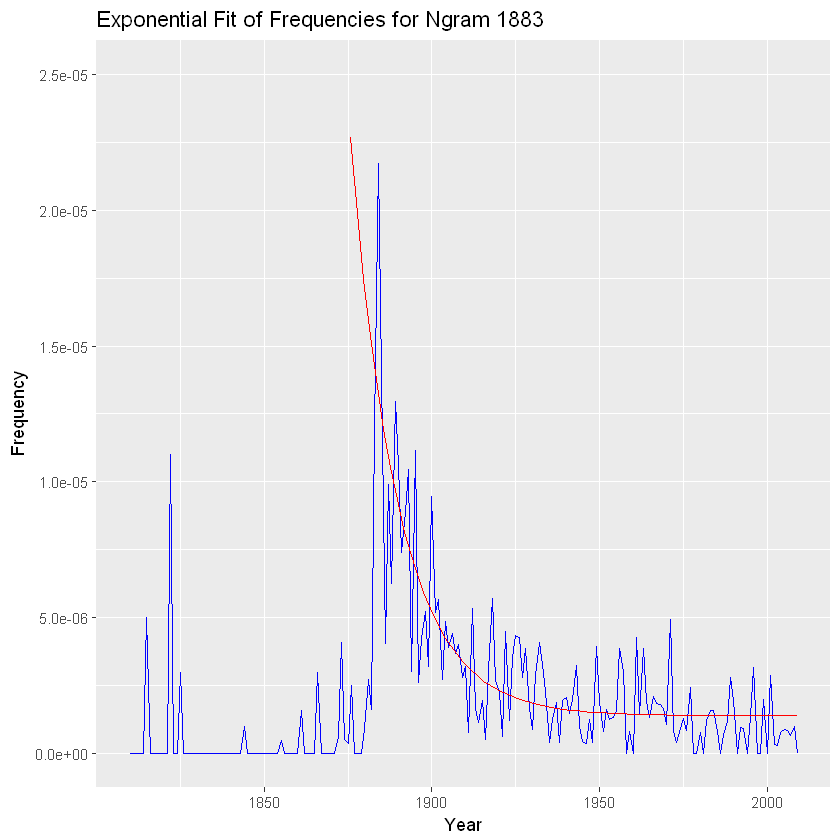

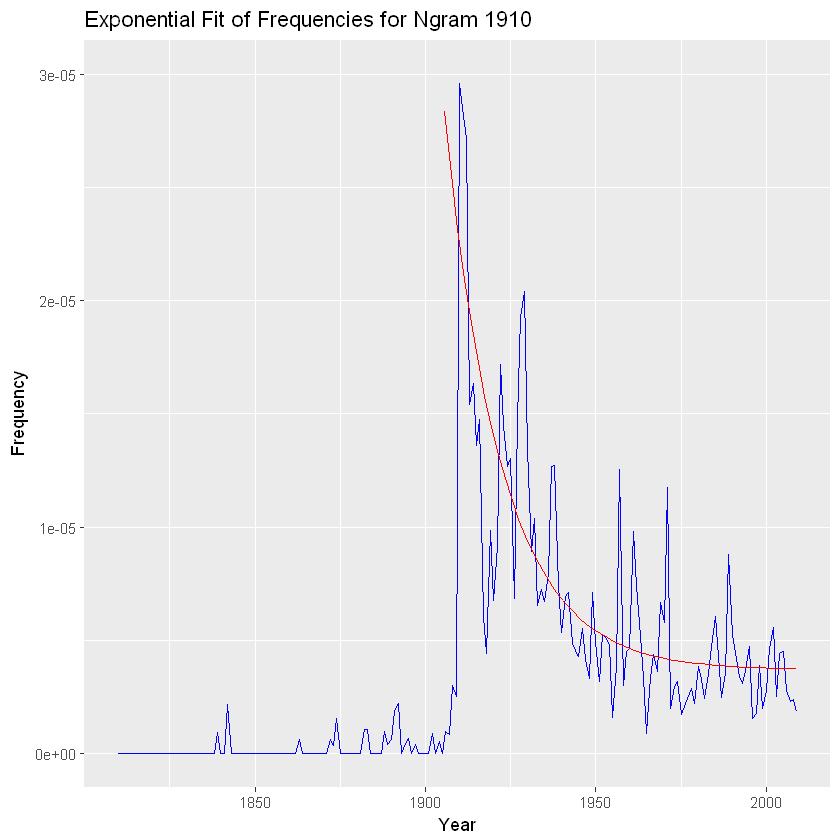

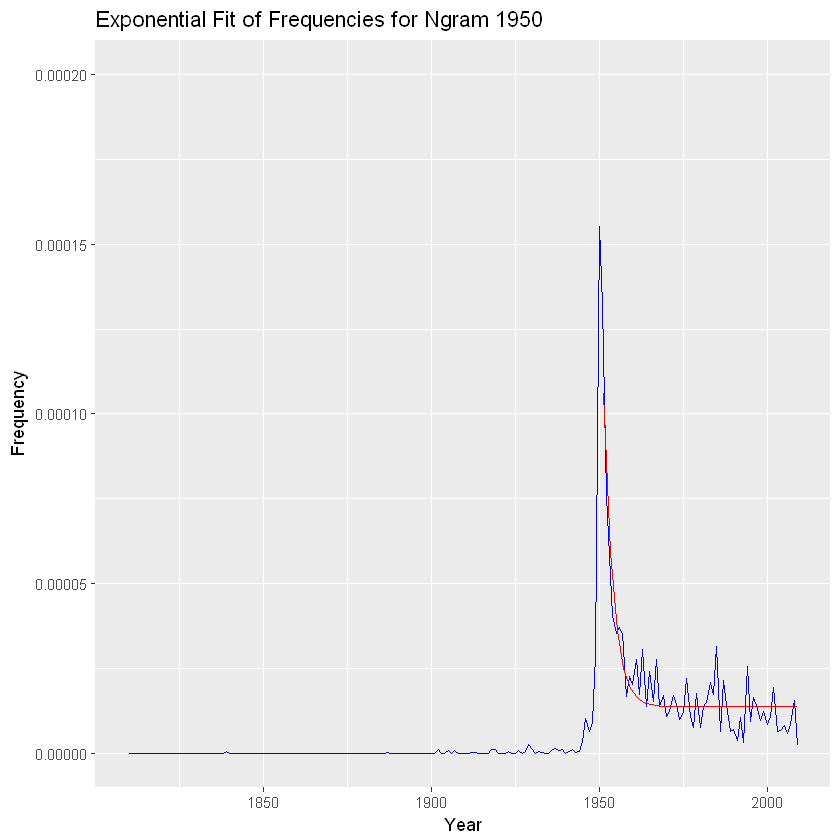

In [10]:
mod.1883 <- compute.exp.fit(counts.1883, 1883);
halflife.exp.1883 <- compute.halflife.expfit(mod.1883);
sprintf("Year: %s \t Halflife: %s", 1883, halflife.exp.1883);
a.1883 <- getElement(coef(mod.1883), 'a');
b.1883 <- getElement(coef(mod.1883), 'b');
c.1883 <- getElement(coef(mod.1883), 'c');
fun.1883 <- function(x) a.1883 * exp(b.1883 * (x - 1883)) + c.1883;

mod.1910 <- compute.exp.fit(counts.1910, 1910);
halflife.exp.1910 <- compute.halflife.expfit(mod.1910);
sprintf("Year: %s \t Halflife: %s", 1910, halflife.exp.1910);
a.1910 <- getElement(coef(mod.1910), 'a');
b.1910 <- getElement(coef(mod.1910), 'b');
c.1910 <- getElement(coef(mod.1910), 'c');
fun.1910 <- function(x) a.1910 * exp(b.1910 * (x - 1910)) + c.1910;

mod.1950 <- compute.exp.fit(counts.1950, 1950);
halflife.exp.1950 <- compute.halflife.expfit(mod.1950);
sprintf("Year: %s \t Halflife: %s", 1950, halflife.exp.1950);
a.1950 <- getElement(coef(mod.1950), 'a');
b.1950 <- getElement(coef(mod.1950), 'b');
c.1950 <- getElement(coef(mod.1950), 'c');
fun.1950 <- function(x) a.1950 * exp(b.1950 * (x - 1950)) + c.1950;

years.1883 <- as.data.frame(c(1883:2010));
years.1910 <- as.data.frame(c(1910:2010));
years.1950 <- as.data.frame(c(1950:2010));

ggplot()+ 
  geom_line(data=counts.1883, aes(x=YEAR, y=FREQ), color="blue") +
  stat_function(data=years.1883,fun = fun.1883, color="red") + 
  ylim(0, 0.000025) +
  xlab('Year') +
  ylab('Frequency') +
  ggtitle('Exponential Fit of Frequencies for Ngram 1883');

ggplot()+ 
  geom_line(data=counts.1910, aes(x=YEAR, y=FREQ), color="blue") +
  stat_function(data=years.1910,fun = fun.1910, color="red") + 
  ylim(0, 0.00003) +
  xlab('Year') +
  ylab('Frequency') +
  ggtitle('Exponential Fit of Frequencies for Ngram 1910');

ggplot()+ 
  geom_line(data=counts.1950, aes(x=YEAR, y=FREQ), color="blue") +
  stat_function(data=years.1950,fun = fun.1950, color="red") + 
  ylim(0, 0.0002) +
  xlab('Year') +
  ylab('Frequency') +
  ggtitle('Exponential Fit of Frequencies for Ngram 1950');


## <strong>2. One of the criticisms of the Google NGrams corpus is that it over-represents academic literature. The COHA Corpus categorizes texts according to four categories (Fiction, Magazines, Newspapers, and Nonfiction) and provides the percent representation of each category for each year. Can you categories from the COHA database show if the "forgetting faster" effect is caused by an over-representation of academic literature?</strong>

In question 1, we saw that the overall COHA corpus similarly shows exponential decay, but did not show decreasing half-lives for the ngrams 1883, 1910, and 1950. We can look separately at ngrams from the four COHA categories, but we don't find a forgetting faster effect in any of these categories, either.

However, it's possible that the categories are not specific enough (academic articles might fit under nonfiction, but looking only at the 'NF' category includes other non-fiction texts as well). From a [description of the COHA corpus](http://davies-linguistics.byu.edu/ling450/davies_corpora_2011.pdf), the corpus categories includes texts from the following sources:
* Fiction: Project Gutenberg, Making of America, scanned books, movie and play scripts, and COCA
* Magazines: Making of America, scanned and PDF magazines, and COCA
* Newspapers: At least five different newspapers, COCA, and others
* Nonfiction: Project Gutenberg, www.archive.org, scanned books, and COCA

Also, since category counts are only available by decade, it's possible that aggregating the counts over each decade hides a trend.

In [11]:
get.category.counts <- function(context.df) {
    category.counts.df <- data.frame(decade=seq(1810, 2000, 10), count=rep.int(0, (2000 - 1810) / 10 + 1));
    for (decade in category.counts.df$decade) {
        context.decade <- context.df[context.df$YEAR - decade >= 0 & context.df$YEAR - decade < 10,];
        decade.count <- nrow(context.decade);
        category.counts.df[category.counts.df$decade == decade, 'count'] = decade.count;
    }
    return(category.counts.df);
}

compute.exp.fit.categories <- function(counts.df, year) {
    counts.from.year <- counts.df[counts.df$YEAR >= year,];
    freqs.from.year <- counts.from.year$FREQ;
    temp <- data.frame(y = freqs.from.year, x = counts.from.year$YEAR);
    temp[temp$y == 0, 'y'] <- 1e-10; # Prevent -Inf from taking the log.
    mod <- lm(log(temp$y)~ temp$x)
    return(mod);
}

create.category.plots <- function(category) {
    decades.counts.df.category <- decades.counts.df[category];
    
    category.df.1883 <- context.df.1883[context.df.1883$TYPE == category,];
    category.df.1910 <- context.df.1910[context.df.1910$TYPE == category,];
    category.df.1950 <- context.df.1950[context.df.1950$TYPE == category,];
    
    decades.counts.df.category[decades.counts.df.category == 0] <- Inf; # avoid dividing by zero.

    # Frequency data for this category.
    category.freqs.1883 <- data.frame(FREQ=get.category.counts(category.df.1883)$count / decades.counts.df.category);
    category.freqs.1883$YEAR <- decades.counts.df$Decade;
    names(category.freqs.1883) <- c('FREQ', 'YEAR');
    
    category.freqs.1910 <- data.frame(FREQ=get.category.counts(category.df.1910)$count / decades.counts.df.category);
    category.freqs.1910$YEAR <- decades.counts.df$Decade;
    names(category.freqs.1910) <- c('FREQ', 'YEAR');
    
    category.freqs.1950 <- data.frame(FREQ=get.category.counts(category.df.1950)$count / decades.counts.df.category);
    category.freqs.1950$YEAR <- decades.counts.df$Decade;
    names(category.freqs.1950) <- c('FREQ', 'YEAR');

    # Exponential fit and halflife for this category.
    mod.category.1883 <- compute.exp.fit.categories(category.freqs.1883, 1883);
    A.1883 <- getElement(coef(mod.category.1883), '(Intercept)');
    b.1883 <- getElement(coef(mod.category.1883), 'temp$x');
    fun.1883 <- function(x) exp(A.1883) * exp(b.1883 * x);
    halflife.1883 <- log(2) / (-1 * b.1883);
 
    mod.category.1910 <- compute.exp.fit.categories(category.freqs.1910, 1910);
    A.1910 <- getElement(coef(mod.category.1910), '(Intercept)');
    b.1910 <- getElement(coef(mod.category.1910), 'temp$x');
    fun.1910 <- function(x) exp(A.1910) * exp(b.1910 * x);
    halflife.1910 <- log(2) / (-1 * b.1910);
    
    mod.category.1950 <- compute.exp.fit.categories(category.freqs.1950, 1950);
    A.1950 <- getElement(coef(mod.category.1950), '(Intercept)');
    b.1950 <- getElement(coef(mod.category.1950), 'temp$x');
    fun.1950 <- function(x) exp(A.1950) * exp(b.1950 * x);
    halflife.1950 <- log(2) / (-1 * b.1950);
    
    print(paste0("Category: ", category));
    print(sprintf("Year: %s  Halflife: %s", 1883, halflife.1883));
    print(sprintf("Year: %s  Halflife: %s", 1910, halflife.1910));
    print(sprintf("Year: %s  Halflife: %s", 1950, halflife.1950));
 
    plot(ggplot()+ 
      geom_point(data=category.freqs.1883, aes(x=YEAR, y=FREQ), color="blue") +
      geom_point(data=category.freqs.1910, aes(x=YEAR, y=FREQ), color="green") +
      geom_point(data=category.freqs.1950, aes(x=YEAR, y=FREQ), color="red") +
      stat_function(data=years.1883 - 1883,fun = fun.1883, color="blue") + 
      stat_function(data=years.1910 - 1910,fun = fun.1910, color="green") + 
      xlab('Year') +
      ylab('Frequency') +
      ggtitle(paste('Exponential Fit of Frequencies for ', category,"")));
}

In [12]:
decades.filename <- 'coha_decade_counts.csv';
decades.counts.df <- read.counts(decades.filename);
names(decades.counts.df) <- c('Decade', 'FIC', 'MAG', 'NEWS', 'NF', 'TOTAL', 'PERCENT_FIC');

context.filename.1883 <- 'coha_1883_clean.txt';
context.filename.1910 <- 'coha_1910_clean.txt';
context.filename.1950 <- 'coha_1950_clean.txt';

context.df.1883 <- read.context(context.filename.1883);
context.df.1910 <- read.context(context.filename.1910);
context.df.1950 <- read.context(context.filename.1950);

[1] "Category: FIC"
[1] "Year: 1883  Halflife: 20.5832593951434"
[1] "Year: 1910  Halflife: 47.1032159613743"
[1] "Year: 1950  Halflife: -112.114236397775"


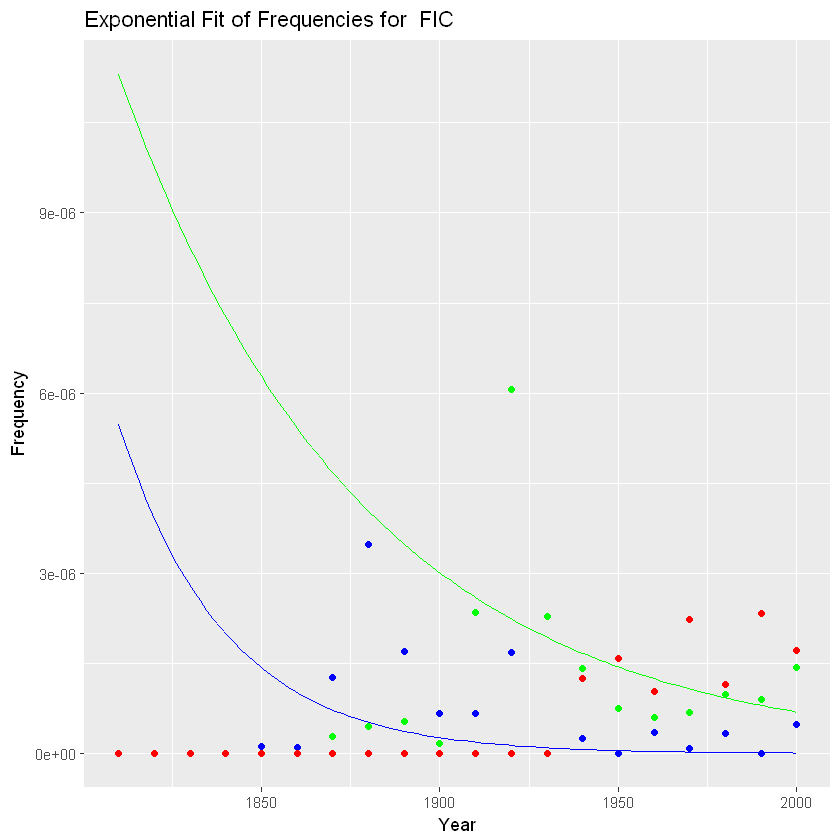

In [13]:
create.category.plots('FIC');

[1] "Category: MAG"
[1] "Year: 1883  Halflife: 34.3263325903359"
[1] "Year: 1910  Halflife: 36.6700105223416"
[1] "Year: 1950  Halflife: 18.6925908563743"


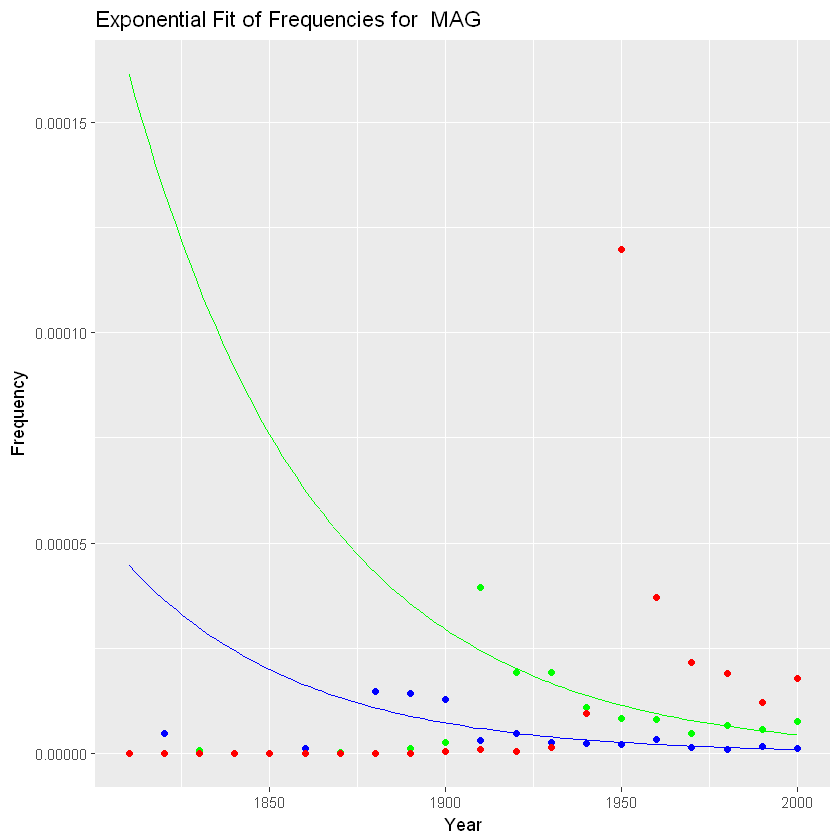

In [14]:
create.category.plots('MAG');

[1] "Category: NEWS"
[1] "Year: 1883  Halflife: 27.3080180088199"
[1] "Year: 1910  Halflife: 26.6157883579553"
[1] "Year: 1950  Halflife: 14.3475969016858"


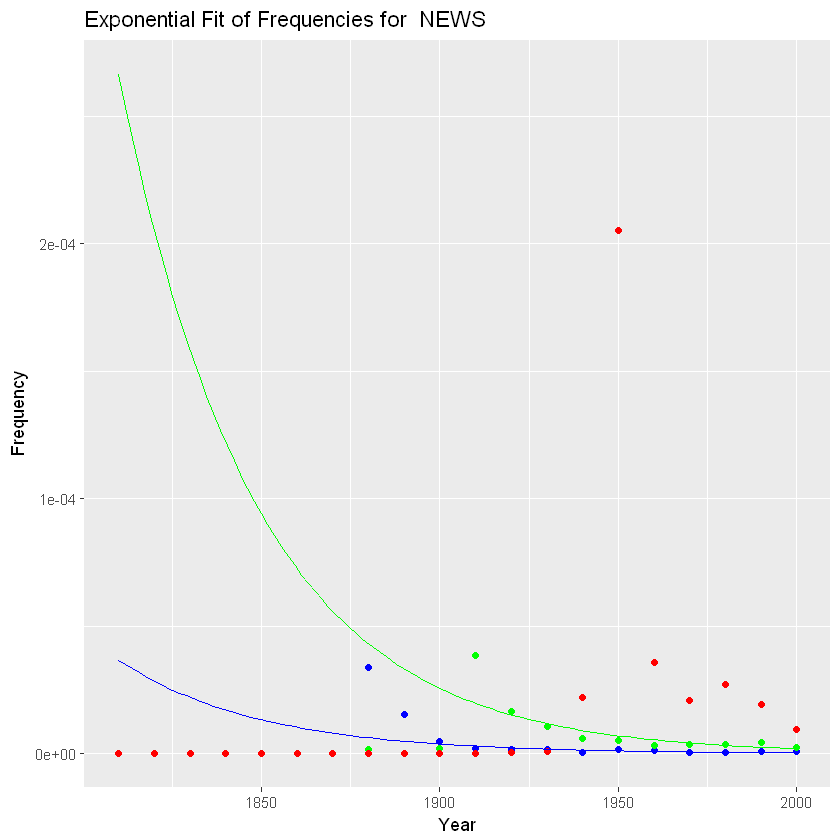

In [15]:
create.category.plots('NEWS');

[1] "Category: NF"
[1] "Year: 1883  Halflife: 115.207276373585"
[1] "Year: 1910  Halflife: 52.2557075786788"
[1] "Year: 1950  Halflife: 87.9118388968625"


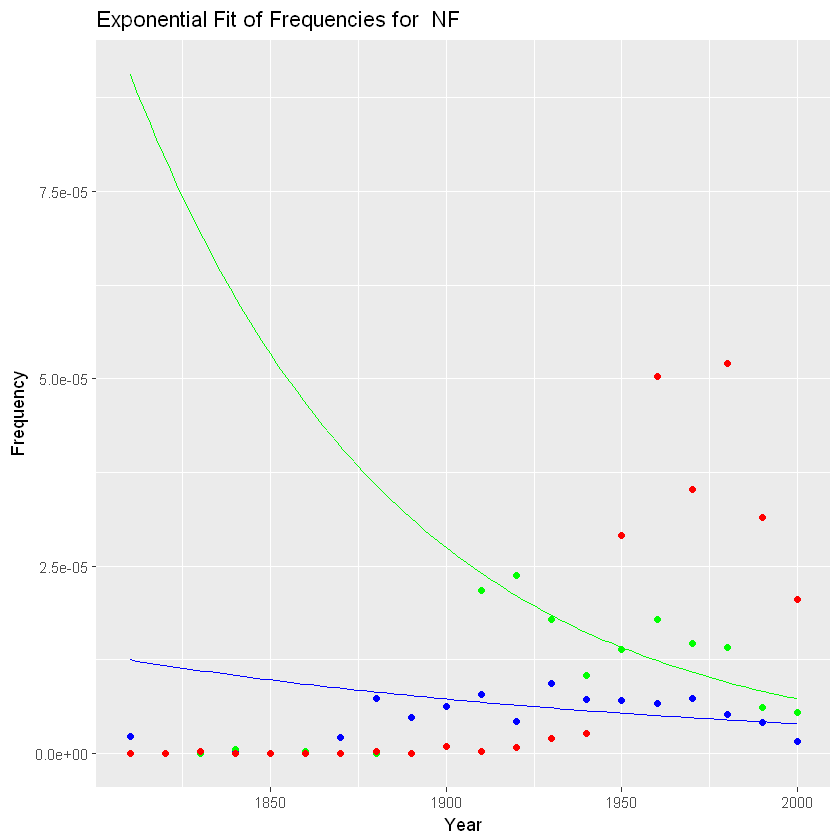

In [16]:
create.category.plots('NF');

Although these categories don't allow us to directly check if the "forgetting faster" effect comes from an overrepresentation of academic literature, the 'newspaper' and 'magazine' categories could indicate whether society is forgetting faster (since newspapers and magazines might correspond more closely to what people talk about). The frequencies of the three selected ngrams do not show decreasing halflives.

## <strong>3. The COHA corpus also contains information about each ngram's context. Another criticism of Google NGrams is that it does not give any information about the context of ngrams in the corpus. What (if any) additional understanding can you gain from the contexts provided in the COHA corpus data?</strong>

Although there are too many ngrams to look at each one's context individually, we can sample the contexts to see whether year ngrams are actually being used to describe years. Since the COHA corpus also separates by category, we can see how this representation differs across categories.

In [17]:
categories <- c('FIC', 'MAG', 'NEWS', 'NF');

for (category in categories) {
    category.df.1883 <- context.df.1883[context.df.1883$TYPE == category,];
    category.df.1910 <- context.df.1910[context.df.1910$TYPE == category,];
    category.df.1950 <- context.df.1950[context.df.1950$TYPE == category,];

    print(sprintf("*******Contexts for category %s*******", category));

    print("*****Contexts for ngram 1883*****");
    print(category.df.1883[sample(nrow(category.df.1883), 10), 'CONTEXT']);
    cat(sprintf("\n\n"));
    
    print("*****Contexts for ngram 1910*****");
    print(category.df.1910[sample(nrow(category.df.1910), 10), 'CONTEXT']);
    cat(sprintf("\n\n"));
    
    print("*****Contexts for ngram 1950*****");
    print(category.df.1950[sample(nrow(category.df.1950), 10), 'CONTEXT']);
    cat(sprintf("\n\n\n\n"));
}

[1] "*******Contexts for category FIC*******"
[1] "*****Contexts for ngram 1883*****"
 [1] "in a Shoe, "" Etc. Boston Lee and Shepard Publishers 1899 Copyright, 1883, By Lee and Shepard. All rights reserved. TO DR. AND MRS"                                       
 [2] "great spectacular possibilities in the play. -- New York Herald, February 27, 1883. The piece is well-calculated to please, for, although it deals with ancient"          
 [3] "New York saw Siberia at Haverly's 14th Street Theatre, February 26-March 29, 1883, with the following cast (in part): Sara Georgie Cayvan Marie Blanche"                  
 [4] "settled in Brown County, Dakota, he drifted that way in the spring of 1883 and took up a claim in McPherson County, where he lived for a year"                            
 [5] it on tour during the season of 1880-81. It was played in Chicago in 1883 and again in 1895. Tradition has it that The Virginian was very popular in                       
 [6] "bibliography, see Who's

Although a instances use the ngram in contexts such as citations, it seems like most of the contexts use the ngram to refer to the year itself. This supports the 'culturomic' idea that ngram frequencies show how often writers refer to a year.

Ngrams from the "Fiction" category seem to show a higher proportion of contexts that use the ngram in a citation, rather than in reference to the specific year. This might explain the difference between the frequency plots for "FIC" and the frequency plots for the other three categories in Part 2.

Each context is relatively short, which makes it difficult to gain a lot of information about how these ngrams are used in their respective texts. However, using the contexts we can look at the words that are most frequently used with each ngram.

In [18]:
library(tm)

Loading required package: NLP

Attaching package: 'NLP'

The following object is masked from 'package:ggplot2':

    annotate



In [19]:
years <- seq(1810, 2009)
corpuses <- list()
context.filename.1883 <- 'coha_1883_clean.txt';
context.filename.1910 <- 'coha_1910_clean.txt';
context.filename.1950 <- 'coha_1950_clean.txt';
context.filename.influenza <- 'coha_influenza_clean.txt';
context.filename.feminism <- 'coha_feminism_clean.txt';

context.df.1883 <- read.context(context.filename.1883);
context.df.1910 <- read.context(context.filename.1910);
context.df.1950 <- read.context(context.filename.1950);
context.df.influenza <- read.context(context.filename.influenza);
context.df.feminism <- read.context(context.filename.feminism);

contexts.1883 <- paste(context.df.1883[,'CONTEXT'], collapse = "");
contexts.1910 <- paste(context.df.1910[,'CONTEXT'], collapse = "");
contexts.1950 <- paste(context.df.1950[,'CONTEXT'], collapse = "");
contexts.influenza <- paste(context.df.influenza[,'CONTEXT'], collapse = "");
contexts.feminism <- paste(context.df.feminism[,'CONTEXT'], collapse = "");

names <- c('1883', '1910', '1950', 'influenza', 'feminism');

In [20]:
corpuses <- c(contexts.1883, contexts.1910, contexts.1950, contexts.influenza, contexts.feminism);
#corpuses <- c(contexts.1883);
docs <- Corpus(VectorSource(corpuses));

In [21]:
clean.docs <- function(docs) {
    # From https://eight2late.wordpress.com/2015/05/27/a-gentle-introduction-to-text-mining-using-r/
    docs <- tm_map(docs,content_transformer(tolower));
    toSpace <- content_transformer(function(x, pattern) { return (gsub(pattern, " ", x))});
    docs <- tm_map(docs, toSpace, "-");
    docs <- tm_map(docs, toSpace, "’");
    docs <- tm_map(docs, toSpace, "‘");
    docs <- tm_map(docs, toSpace, "•");
    docs <- tm_map(docs, toSpace, "”");
    docs <- tm_map(docs, toSpace, "“");
    #remove punctuation
    docs <- tm_map(docs, removePunctuation);
    #Strip digits
    docs <- tm_map(docs, removeNumbers);
    #remove stopwords
    docs <- tm_map(docs, removeWords, stopwords("english"));
    #remove whitespace
    docs <- tm_map(docs, stripWhitespace);
    #Stem document
    docs <- tm_map(docs,stemDocument);
    return(docs);
}

In [22]:
docs <- clean.docs(docs)
#Create document-term matrix
dtm <- DocumentTermMatrix(docs);
#convert rownames to filenames
rownames(dtm) <- names;

for (row in 1:5) {
    #collapse matrix by summing over columns
    freq <- as.matrix(dtm)[row,];
    #length should be total number of terms
    length(freq);
    #create sort order (descending)
    ord <- order(freq,decreasing=TRUE);
    #List all terms in decreasing order of freq and write to disk
    print(rownames(dtm)[row]);
    print(freq[ord][1:10]);
}

[1] "1883"
 year   new   one   act first   law state  time  made  sinc 
  101    69    58    48    48    45    45    43    40    40 
[1] "1910"
 year   new state   per  sinc  cent first   one  made  york 
  225   152   124   121   113   106   105   105    85    81 
[1] "1950"
   new   year   york   time   sinc  state editor  first    one nation 
   544    410    400    288    269    218    200    198    182    160 
[1] "influenza"
influenza     virus    epidem    diseas    vaccin       die      year       one 
      748       106        84        79        67        58        57        56 
pneumonia    infect 
       48        45 
[1] "feminism"
   femin    women      men      new      one    right feminist movement 
     311       81       32       29       28       28       27       24 
   radic    polit 
      21       20 


In [23]:
print.freq.words.yearly <- function(context.df) {
    years <- seq(1810, 2009);
    corpuses.yearly <- c();

    for (year in years) {
        context.df.year <- context.df[context.df$YEAR == year,];
        corpuses.year <- paste(context.df.year[,'CONTEXT'], collapse = "");
        corpuses.yearly <- c(corpuses.yearly, corpuses.year);
    }

    docs.yearly <- Corpus(VectorSource(corpuses.yearly));
    docs.yearly <- clean.docs(docs.yearly);
    
    dtm.yearly <- DocumentTermMatrix(docs.yearly);
    #convert rownames to filenames
    rownames(dtm.yearly) <- years;
    num.years <- nrow(dtm.yearly);

    for (i in seq(1:num.years)) {
        #collapse matrix by summing over columns
        freq <- as.matrix(dtm.yearly)[i,];
        total.words <- sum(freq);
        if (total.words > 0) {
            #length should be total number of terms
            length(freq);
            #create sort order (descending)
            ord <- order(freq,decreasing=TRUE);
            #List all terms in decreasing order of freq and write to disk
            print(rownames(dtm.yearly)[i]);
            print(freq[ord][1:3]);
        }
    }
}

We can also try to look at how words used with the ngrams change over time, but it the size of the corpus might limit this analysis: when we break down the corpuses by year, the most frequently used terms only occur a few times in the given year.

In [24]:
print.freq.words.yearly(context.df.1883)

[1] "1815"
  dodg   year almost 
     2      2      1 
[1] "1822"
overtur concert   first 
      6       3       3 
[1] "1825"
address    alon  boston 
      1       1       1 
[1] "1844"
chapter    ever   india 
      1       1       1 
[1] "1855"
            car           sleep ccxcoventryacuk 
              2               2               1 
[1] "1861"
noth  add  ask 
   2    1    1 
[1] "1866"
   cold countri describ 
      2       2       2 
[1] "1872"
   felton septimius    elixir 
        2         2         1 
[1] "1873"
york  new week 
   5    4    4 
[1] "1874"
 cure devil  fear 
    1     1     1 
[1] "1875"
      xii   charter christian 
        2         1         1 
[1] "1876"
    also schrader      alt 
       6        3        2 
[1] "1880"
pounc april bijou 
    2     1     1 
[1] "1881"
copyright     harri       new 
        2         2         2 
[1] "1882"
   claim democrat  general 
       2        2        2 
[1] "1883"
illustr     new chapter 
      6       6    

In [25]:
print.freq.words.yearly(context.df.1910)

[1] "1839"
 actual    born certain 
      1       1       1 
[1] "1842"
 popul   year almost 
     2      2      1 
[1] "1863"
address  antiqu  associ 
      1       1       1 
[1] "1872"
     new scribner   accord 
       2        2        1 
[1] "1873"
galley  slave averag 
     2      2      1 
[1] "1874"
  year appear   bank 
     2      1      1 
[1] "1882"
  chapter   compani copyright 
        2         2         2 
[1] "1883"
copyright    bonner     charl 
        3         1         1 
[1] "1888"
railroad     bond  charter 
       2        1        1 
[1] "1889"
   time   forti neither 
      2       1       1 
[1] "1890"
   cent   claim disprov 
      1       1       1 
[1] "1891"
   year    citi compani 
      5       3       3 
[1] "1892"
   henri foreword     hour 
       3        2        2 
[1] "1894"
 age call  end 
   1    1    1 
[1] "1895"
 copi first  june 
    1     1     1 
[1] "1897"
   compani lippincott  copyright 
         2          2          1 
[1] "1902"
w

In [26]:
print.freq.words.yearly(context.df.1950)

[1] "1839"
 school brought   child 
      2       1       1 
[1] "1887"
 hcl solv zncl 
   1    1    1 
[1] "1902"
will  may  one 
   3    2    2 
[1] "1905"
  state alreadi   anoth 
      2       1       1 
[1] "1907"
centuri    citi   close 
      1       1       1 
[1] "1912"
anglophob      book     bring 
        1         1         1 
[1] "1913"
  crop   alon bushel 
     2      1      1 
[1] "1918"
acquir   asid   base 
     1      1      1 
[1] "1919"
divorc   hand   will 
     2      2      2 
[1] "1923"
   call    coal histori 
      1       1       1 
[1] "1926"
  believ     cant children 
       1        1        1 
[1] "1928"
presid  becam   book 
     2      1      1 
[1] "1929"
entrepreneur        estim         abil 
           4            3            2 
[1] "1930"
   mani project     use 
      2       2       2 
[1] "1932"
    bank abstract  account 
       2        1        1 
[1] "1933"
 aug bond cent 
   2    1    1 
[1] "1936"
publish  amazon brussel 
      2     

In [27]:
print.freq.words.yearly(context.df.influenza)

[1] "1815"
    everyth adelaiderun         bar 
          2           1           1 
[1] "1832"
influenza     agenc    banker 
        2         1         1 
[1] "1834"
influenza      like      seem 
        2         2         2 
[1] "1838"
influenza     actor     buckl 
        2         1         1 
[1] "1840"
ixion alway   got 
    2     1     1 
[1] "1842"
  boy chief equal 
    1     1     1 
[1] "1843"
chief equal fatal 
    1     1     1 
[1] "1850"
influenza    effect      like 
        5         2         2 
[1] "1851"
 affect buoyant   chang 
      1       1       1 
[1] "1853"
   attend      hard influenza 
        1         1         1 
[1] "1854"
 influenza partington     answer 
         2          2          1 
[1] "1855"
ceylon  class  cough 
     1      1      1 
[1] "1858"
acquaint    among  debilit 
       1        1        1 
[1] "1860"
attack attain eighti 
     2      1      1 
[1] "1863"
adroit attack   dyce 
     1      1      1 
[1] "1864"
   ada afford belong

In [28]:
print.freq.words.yearly(context.df.feminism)

[1] "1904"
  unright     cours deliquesc 
        2         1         1 
[1] "1905"
   femin      men masculin 
       3        3        2 
[1] "1907"
   anyth    bring encourag 
       4        2        2 
[1] "1910"
 femin theori   alli 
     2      2      1 
[1] "1912"
 busi femin found 
    1     1     1 
[1] "1914"
communiti     femin  absurdum 
        2         2         1 
[1] "1915"
femin   met  must 
    1     1     1 
[1] "1916"
femin   day europ 
    5     2     2 
[1] "1917"
 admit  arena defeat 
     1      1      1 
[1] "1919"
    woman accompani     cipat 
        2         1         1 
[1] "1920"
   chines christian  confeder 
        1         1         1 
[1] "1921"
 femin   will advanc 
     3      2      1 
[1] "1922"
femin  aand   act 
    3     1     1 
[1] "1923"
 femin  black direct 
     7      2      2 
[1] "1925"
  femin  answer attitud 
     13       3       3 
[1] "1926"
 applaud   ardent broadway 
       1        1        1 
[1] "1928"
femin appli  back 


## Additional Plots, with Rolling Averages

In [29]:
# Get data for each ngram.
countsfilename.1883 = "coha_1883_counts.csv";
counts.1883 = read.counts(countsfilename.1883);
counts.1883$FREQ = counts.1883$NUM_PER_MILLION * 1.0 / 1000000;

countsfilename.1910 = "coha_1910_counts.csv";
counts.1910 = read.counts(countsfilename.1910);
counts.1910$FREQ = counts.1910$NUM_PER_MILLION * 1.0 / 1000000;

countsfilename.1950 = "coha_1950_counts.csv";
counts.1950 = read.counts(countsfilename.1950);
counts.1950$FREQ = counts.1950$NUM_PER_MILLION * 1.0 / 1000000;

countsfilename.influenza = "coha_influenza_counts.csv";
counts.influenza = read.counts(countsfilename.influenza);
counts.influenza$FREQ = counts.influenza$NUM_PER_MILLION * 1.0 / 1000000;

countsfilename.feminism = "coha_feminism_counts.csv";
counts.feminism = read.counts(countsfilename.feminism);
counts.feminism$FREQ = counts.feminism$NUM_PER_MILLION * 1.0 / 1000000;

years = counts.1883$YEAR

In [30]:
n <- 3
window.half <- (n - 1) / 2 + 1

cumsum.1883 <- cumsum(counts.1883$FREQ)
len.1883 <- length(counts.1883$FREQ)
upper.1883 <- cumsum.1883[(window.half + 1):len.1883]
lower.1883 <- c(0, cumsum.1883[1:(len.1883 - window.half - 1)])
rsum.1883 <- (upper.1883 - lower.1883) / n

cumsum.1910 <- cumsum(counts.1910$FREQ)
len.1910 <- length(counts.1910$FREQ)
upper.1910 <- cumsum.1910[(window.half + 1):len.1910]
lower.1910 <- c(0, cumsum.1910[1:(len.1910 - window.half - 1)])
rsum.1910 <- (upper.1910 - lower.1910) / n

cumsum.1950 <- cumsum(counts.1950$FREQ)
len.1950 <- length(counts.1950$FREQ)
upper.1950 <- cumsum.1950[(window.half + 1):len.1950]
lower.1950 <- c(0, cumsum.1950[1:(len.1950 - window.half - 1)])
rsum.1950 <- (upper.1950 - lower.1950) / n

cumsum.influenza <- cumsum(counts.influenza$FREQ)
len.influenza <- length(counts.influenza$FREQ)
upper.influenza <- cumsum.influenza[(window.half + 1):len.influenza]
lower.influenza <- c(0, cumsum.influenza[1:(len.influenza - window.half - 1)])
rsum.influenza <- (upper.influenza - lower.influenza) / n

cumsum.feminism <- cumsum(counts.feminism$FREQ)
len.feminism <- length(counts.feminism$FREQ)
upper.feminism <- cumsum.feminism[(window.half + 1):len.feminism]
lower.feminism <- c(0, cumsum.feminism[1:(len.feminism - window.half - 1)])
rsum.feminism <- (upper.feminism - lower.feminism) / n

years.rolling <- years[2:(length(years) - 1)]

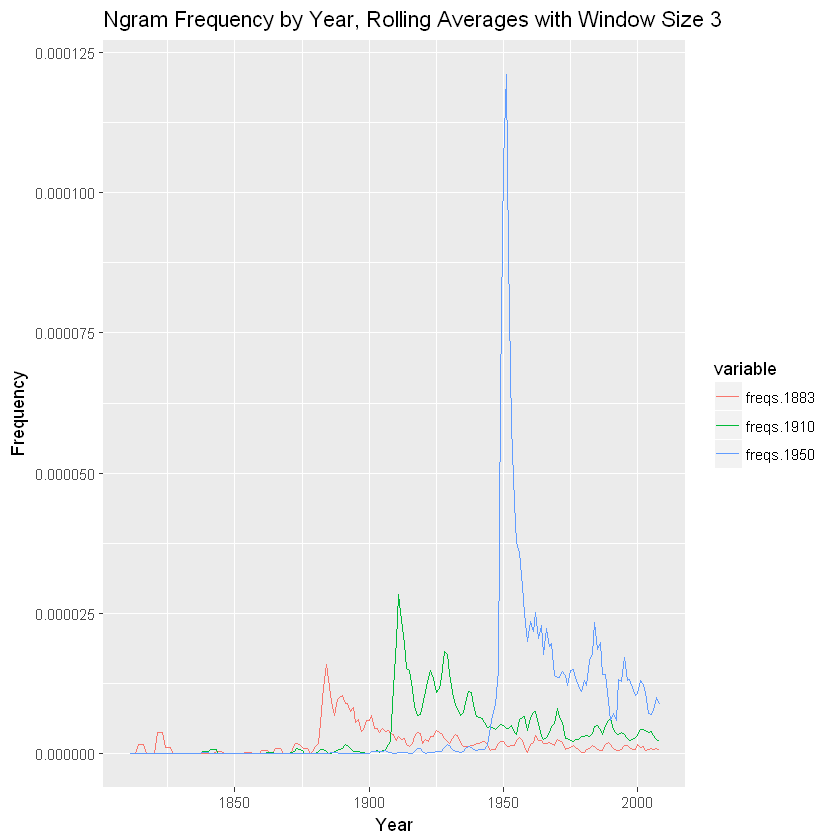

In [31]:
freqs_data_rolling <-
  data.frame(
    freqs.1883 = rsum.1883,
    freqs.1910 = rsum.1910,
    freqs.1950 = rsum.1950,
    year = years.rolling
  );
freqs_data_long <- melt(freqs_data_rolling, id="year")  # convert to long format
ggplot(subset(freqs_data_long, variable %in% c("freqs.1883", "freqs.1910", "freqs.1950")),
       aes(x=year,
           y=value,
           color=variable))+
  geom_line()+
  ggtitle('Ngram Frequency by Year, Rolling Averages with Window Size 3')+
  xlab('Year')+
  ylab('Frequency')

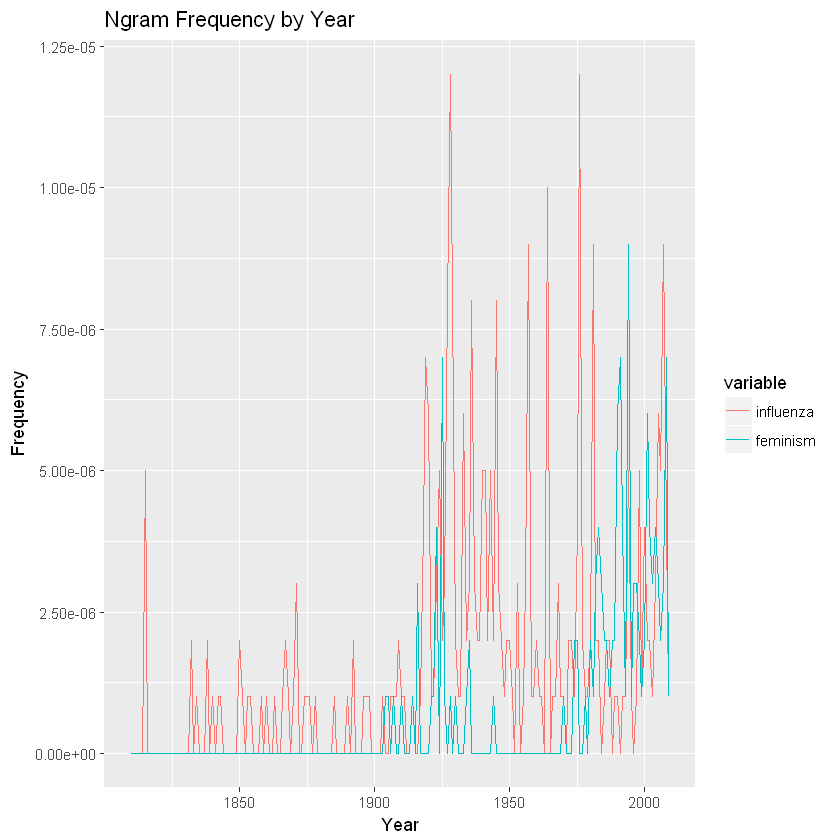

In [32]:
freqs_data <-
  data.frame(
    influenza = counts.influenza$FREQ,
    feminism = counts.feminism$FREQ,
    year = years
  );
freqs_data_long <- melt(freqs_data, id="year")  # convert to long format
ggplot(subset(freqs_data_long, variable %in% c("influenza", "feminism")),
       aes(x=year,
           y=value,
           color=variable))+
  geom_line()+
  ggtitle('Ngram Frequency by Year')+
  xlab('Year')+
  ylab('Frequency')

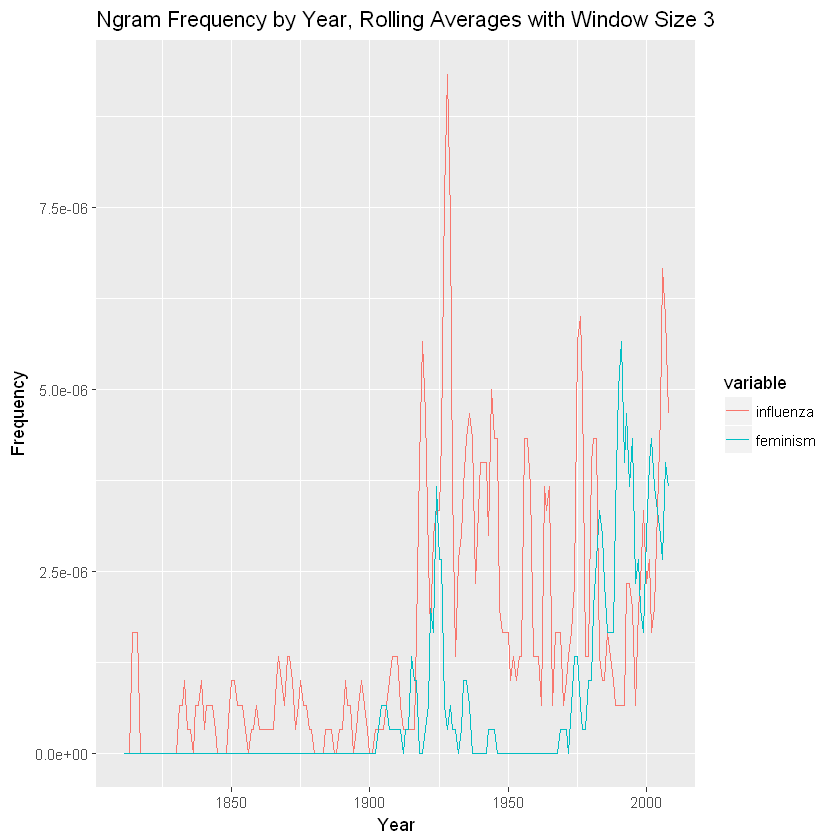

In [33]:
freqs_data_rolling <-
  data.frame(
    influenza = rsum.influenza,
    feminism = rsum.feminism,
    year = years.rolling
  );
freqs_data_long <- melt(freqs_data_rolling, id="year")  # convert to long format
ggplot(subset(freqs_data_long, variable %in% c("influenza", "feminism")),
       aes(x=year,
           y=value,
           color=variable))+
  geom_line()+
  ggtitle('Ngram Frequency by Year, Rolling Averages with Window Size 3')+
  xlab('Year')+
  ylab('Frequency')

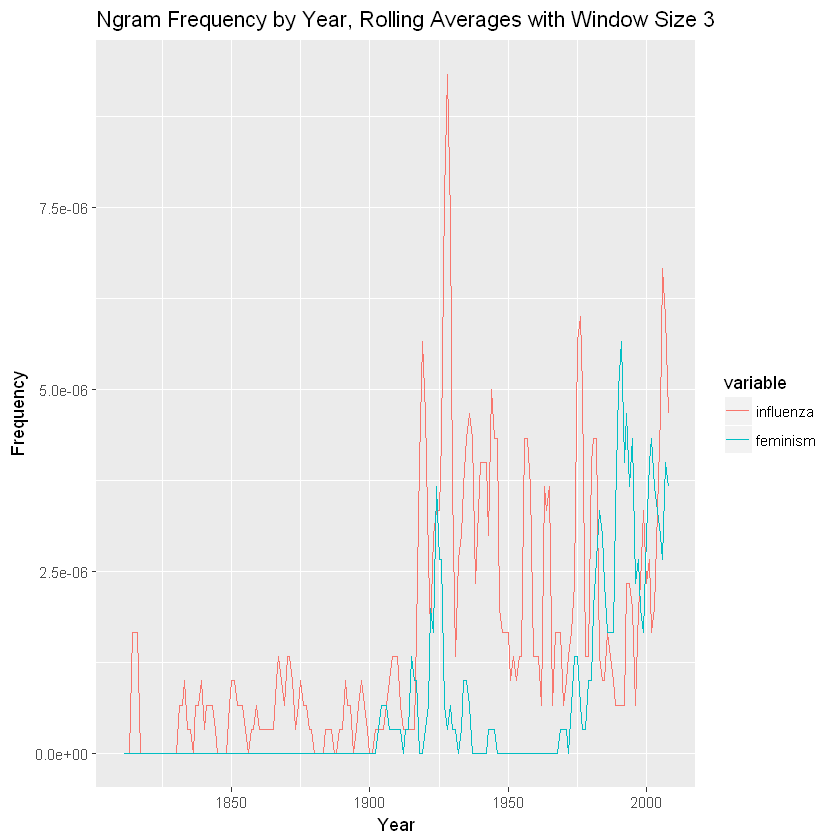

In [34]:
freqs_data_rolling <-
  data.frame(
    influenza = rsum.influenza,
    feminism = rsum.feminism,
    year = years.rolling
  );
freqs_data_long <- melt(freqs_data_rolling, id="year")  # convert to long format
ggplot(subset(freqs_data_long, variable %in% c("influenza", "feminism")),
       aes(x=year,
           y=value,
           color=variable))+
  geom_line()+
  ggtitle('Ngram Frequency by Year, Rolling Averages with Window Size 3')+
  xlab('Year')+
  ylab('Frequency')